# Mesh I/O and manipulation

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant("llvm_ad_rgb")

## Reading a mesh from disk

Mitsuba provides an abstract `Shape` class to handle all geometric shapes. For triangle meshes, it has a concrete class `Mesh` that is further extended by 3 plugins which can load meshes directly from a file:

- [OBJ][1]: handles meshes containing triangles and quadrilaterals from Wavefront OBJ files
- [PLY][2]: handles Stanford PLY format meshes (both the ASCII and binary format)
- [Serialized][3]: Mitsuba 0.6 serialized mesh format.

As any other Mitsuba object, we can use the `load_dict` function to instantiate one of these three plugins. They each have their own specific input parameters which you'll find in their respective documentation, but here are the input parameters they all share:

- **filename**: filename of the mesh file that should be loaded
- **face_normals**: when set to true, any existing or computed vertex normals are discarded and face normals will instead be used during rendering. This gives the rendered object a faceted appearance.
- **to_world**: specifies an linear object-to-world transformation. 

Let's now load a mesh and start playing with it.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_shapes.html#wavefront-obj-mesh-loader-obj
[2]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_shapes.html#ply-stanford-triangle-format-mesh-loader-ply
[3]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_shapes.html#serialized-mesh-loader-serialized

In [2]:
bunny = mi.load_dict({
    "type": "ply",
    "filename": "../scenes/meshes/bunny.ply",
    "face_normals": False,
    "to_world": mi.ScalarTransform4f.rotate([0, 0, 1], angle=10),
})

print(bunny)

PLYMesh[
  name = "bunny.ply",
  bbox = BoundingBox3f[
    min = [-0.0785918, -0.0623055, -0.0730216],
    max = [0.0868213, 0.0980685, 0.0476517]
  ],
  vertex_count = 208349,
  vertices = [4.77 MiB of vertex data],
  face_count = 69451,
  faces = [814 KiB of face data],
  face_normals = 0
]


The string representation of a `Mesh` object gives an overview of its size. If you wish to access some of these values, they are available through the following methods `Shape.bbox()`, `Mesh.vertex_count()`, `Mesh.face_count()`.

## Procedural mesh 

By directly using the `Mesh` class, it is also possible to procedurally create a mesh. To illustrate this, we will build a spanning triangle disk and give it a wavy fringe. The exact details of how the vertex positions and face indices are generated are not important for the purposes of this guide. However, we do leave them as comments in the code.

In [3]:
# Wavy disk construction
#
# Let N define the total number of vertices, the first N-1 vertices will compose
# the fringe of the disk, while the last vertex should be placed at the center.
# The first N-1 vertices must have their height modified such that they oscillate
# with some given frequency and amplitude. To compute the face indices, we define
# the first vertex of every face to be the vertex at the center (idx=N-1) and the
# other two can be assigned sequentially (modulo N-2).

# Disk with a wavy fringe parameters
N = 100
frequency = 12.0
amplitude = 0.4

# Generate the vertex positions
theta = dr.linspace(mi.Float, 0.0, dr.TwoPi, N)
x, y = dr.sincos(theta)
z = amplitude * dr.sin(theta * frequency)
vertex_pos = mi.Point3f(x, y, z)

# Move the last vertex to the center
vertex_pos[dr.eq(dr.arange(mi.UInt32, N), N - 1)] = 0.0

# Generate the face indices
idx = dr.arange(mi.UInt32, N - 1)
face_indices = mi.Vector3u(N - 1, (idx + 1) % (N - 2), idx % (N - 2))

The `Mesh` constructor allocates all the necessary buffers to hold its data. Specifically, the constructor takes as arguments the number of vertices and faces which will then be fixed. It is not possible to edit a mesh in a way that would require the buffers to be resized (more/less faces for examples), a new `Mesh` would need to be created for such use cases.
The constructor can also takes two boolean arguments `has_vertex_normals` and `has_vertex_texcoords` that must also be know at the construction of the object, in order to allocate the appropriate buffers.

In [4]:
# Create an empty mesh (allocates buffers of the correct size)
mesh = mi.Mesh(
    "wavydisk",
    vertex_count=N,
    face_count=N - 1,
    has_vertex_normals=False,
    has_vertex_texcoords=False,
)

In order to assign our existing vertex positions and face indices to the newly created `Mesh` object we will use the `traverse()` mechanism. All of the allocated buffers of a `Mesh` object are exposed, and can therefore be modified with this mechanism. This approach has the advantage of simplifying some of the assignment operations. In addition, if any vertex position is modified, a call to `SceneParameters.update()` will trigger recomputation of both the bounding box and vertex normals.

One caveat here is that meshes in Mitsuba store their data in **flat linear buffers**. Hence it is necessary to change the layout of the array of vertex positions and face indices computed above. Luckily, Dr.Jit provides `dr.ravel()` which does exactly that. The complement of this function is `dr.unravel()` which will convert a flat linear array to a structure-of-array of the specific type (e.g., `Point3f`).

In [5]:
mesh_params = mi.traverse(mesh)
mesh_params["vertex_positions"] = dr.ravel(vertex_pos)
mesh_params["faces"] = dr.ravel(face_indices)
print(mesh_params.update())

[(Mesh[
  name = "wavydisk",
  bbox = BoundingBox3f[
    min = [-0.999874, -0.999497, -0.399547],
    max = [0.999874, 1, 0.399547]
  ],
  vertex_count = 100,
  vertices = [1.17 KiB of vertex data],
  face_count = 99,
  faces = [1.16 KiB of face data],
  face_normals = 0
], {'vertex_positions', 'faces'})]


And now let's take a look at our new mesh!

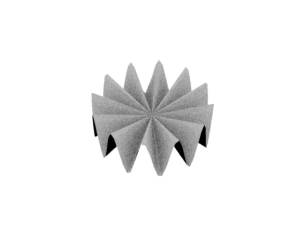

In [6]:
scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "path"},
    "light": {"type": "constant"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0, -5, 5], target=[0, 0, 0], up=[0, 0, 1]
        ),
    },
    "wavydisk": mesh,
})

img = mi.render(scene)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(mi.util.convert_to_bitmap(img));

## Writing a mesh to disk

No matter how a `Mesh` object was loaded or built, it can always be exported to a [PLY file format](https://en.wikipedia.org/wiki/PLY_(file_format)) using the `Mesh.write_ply()` method. No other file formats are currently supported.

<div class="admonition important alert alert-block alert-info">

🗒 **Note**

Any mesh attribute (see below) that is attached to the object at the time when `Mesh.write_ply()` is called will be written to output file as a property. Mitsuba therefore allows you to create complex procedural properties for your meshes and export them to be used in some other context entirely.
</div>

In [7]:
mesh.write_ply("wavydisk.ply")

## Adding and editing attributes

Meshes in Mitsuba can have additional attributes per face or per vertex. Each attribute is either one or several floating point numbers, no other types are supported.

The `Mesh.add_attribute()` methods lets you define new attributes by giving them a name, a number of feilds, and their initial values. The attribute name must be prefixed with either `vertex_` or `face_`, as this defines whether the attribute is defined for each face or for each vertex. For this example, we will be adding a RGB color to each vertex. 

Moreover, Mitsuba 3 has a [mesh attribute][1] texture plugin that conviently allows you to visualize attributes.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_textures.html#mesh-attribute-texture-mesh-attribute

In [8]:
mesh = mi.load_dict({
    "type": "ply",
    "filename": "wavydisk.ply",
    "bsdf": {
        "type": "diffuse",
        "reflectance": {
            "type": "mesh_attribute",
            "name": "vertex_color",  # This will be used to visualize our attribute
        },
    },
})

# Needs to start with vertex_ or face_
attribute_size = mesh.vertex_count() * 3
mesh.add_attribute(
    "vertex_color", 3, [0] * attribute_size
)  # Add 3 floats per vertex (initialized at 0)

Once an attribute is created it can still be modified using the `traverse()` mechanism. As shown below, the attribute's buffer will be exposed with a key corresponding to the attribute's name.

In [9]:
mesh_params = mi.traverse(mesh)
mesh_params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  bsdf.reflectance.scale                        float           MeshAttribute
  vertex_count                                  int             PLYMesh
  face_count                                    int             PLYMesh
  faces                                         UInt            PLYMesh
  vertex_positions                     ∂, D     Float           PLYMesh
  vertex_normals                       ∂, D     Float           PLYMesh
  vertex_texcoords                     ∂        Float           PLYMesh
  vertex_color                         ∂        Float           PLYMesh
]

We can now easily change the values of the attribute using some simple Dr.Jit arithmetic.

In [10]:
N = mesh.vertex_count()

vertex_colors = dr.zero(mi.Float, 3 * N)
fringe_vertex_indices = dr.arange(mi.UInt, N - 1)
dr.scatter(vertex_colors, 1, fringe_vertex_indices * 3)  # Fringe is red
dr.scatter(vertex_colors, 1, [(N - 1) * 3 + 2])  # Center is blue

mesh_params["vertex_color"] = vertex_colors
mesh_params.update()

[(PLYMesh[
    name = "wavydisk.ply",
    bbox = BoundingBox3f[
      min = [-0.999874, -0.999497, -0.399547],
      max = [0.999874, 1, 0.399547]
    ],
    vertex_count = 100,
    vertices = [3.52 KiB of vertex data],
    face_count = 99,
    faces = [1.16 KiB of face data],
    face_normals = 0,
    mesh attributes = [
      vertex_color: 3 floats
    ]
  ],
  {'vertex_color'})]

And visualize the result!

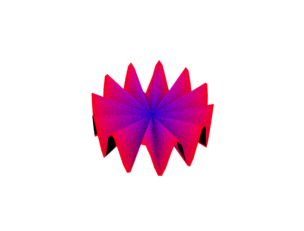

In [11]:
scene = mi.load_dict(
    {
        "type": "scene",
        "integrator": {"type": "path"},
        "light": {"type": "constant"},
        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                origin=[0, -5, 5], target=[0, 0, 0], up=[0, 0, 1]
            ),
        },
        "wavydisk": mesh,
    }
)

img = mi.render(scene)

plt.axis("off")
plt.imshow(mi.util.convert_to_bitmap(img));